In [4]:
# importing necessary libraries
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


In [8]:
#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [9]:
# Genrator takes in a latent vector(random noise) of dimension(100,)
# and outputs an image of size(28,28,1)
# Defining the generator architecture
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

    #Define your generator network    

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    gen_img = model(noise)    #Generated image

    return Model(noise, gen_img)

In [10]:
# the discrinator takes in image of dimensions(28,28,1) and outputs
# the probability of the image being real
# defining the discriminator architecture
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [18]:
# Model Training
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    import gzip
    import sys
    import pickle
    f = gzip.open('mnist.pkl.gz', 'rb')
    if sys.version_info < (3,):
        data = pickle.load(f)
    else:
        data = pickle.load(f, encoding='bytes')
    f.close()
    # (x_train, _), (x_test, _) = data
    (X_train, _), (_, _) = data
    # we are only taking in the actual images and not the other info such as class labels

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    #Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):

        # train the discriminator
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        #take average loss from real and fake images. 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 


        #And within the same loop we train our Generator, by setting the input noise and
        #ultimately training the Generator to have the Discriminator label its samples as valid
        #by specifying the gradient loss.
        
        # Training the generator
        
        #Create noise vectors as input for generator. 
        #Create as many noise vectors as defined by the batch size. 
        #Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


        #Additionally, in order for us to keep track of our training process, we print the
        #progress and save the sample image output depending on the epoch interval specified.  
        # Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)


In [12]:
#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

In [27]:
# Defining other parameters
optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later.
 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image

#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=5000, batch_size=32, save_interval=10)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_63 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_64 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_65 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 5335

/Users/omdeshmukh/Downloads/SemVI/GAN_mnist/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 156ms/step


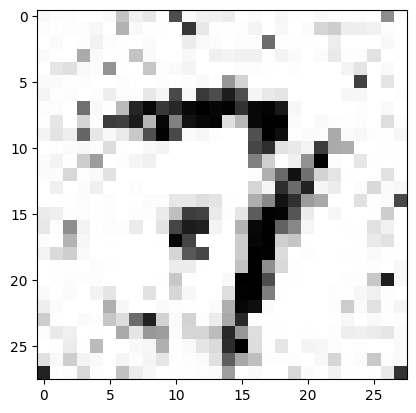

In [28]:
# Prediction from a saved model file
from keras.models import load_model
from matplotlib import pyplot

# load model
model = load_model('generator_model.h5')

#To create same image, suppy same vector each time
# all 0s
#vector = asarray([[0. for _ in range(100)]])  #Vector of all zeros

#To create random images each time...
vector = np.random.randn(100) #Vector of random numbers (creates a column, need to reshape)
vector = vector.reshape(1, 100)

# generate image
X = model.predict(vector)

# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()
